In [1]:
!pip install tensorflow

Epoch 1/100
534/534 [==============================] - 15s 16ms/step - loss: 0.0156
Epoch 2/100
534/534 [==============================] - 9s 18ms/step - loss: 0.0121
Epoch 3/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0116
Epoch 4/100
534/534 [==============================] - 4s 7ms/step - loss: 0.0114
Epoch 5/100
534/534 [==============================] - 6s 11ms/step - loss: 0.0113
Epoch 6/100
534/534 [==============================] - 4s 7ms/step - loss: 0.0112
Epoch 7/100
534/534 [==============================] - 4s 7ms/step - loss: 0.0111
Epoch 8/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0109
Epoch 9/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0109
Epoch 10/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0107
Epoch 11/100
534/534 [==============================] - 9s 17ms/step - loss: 0.0106
Epoch 12/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0105
Epoch 

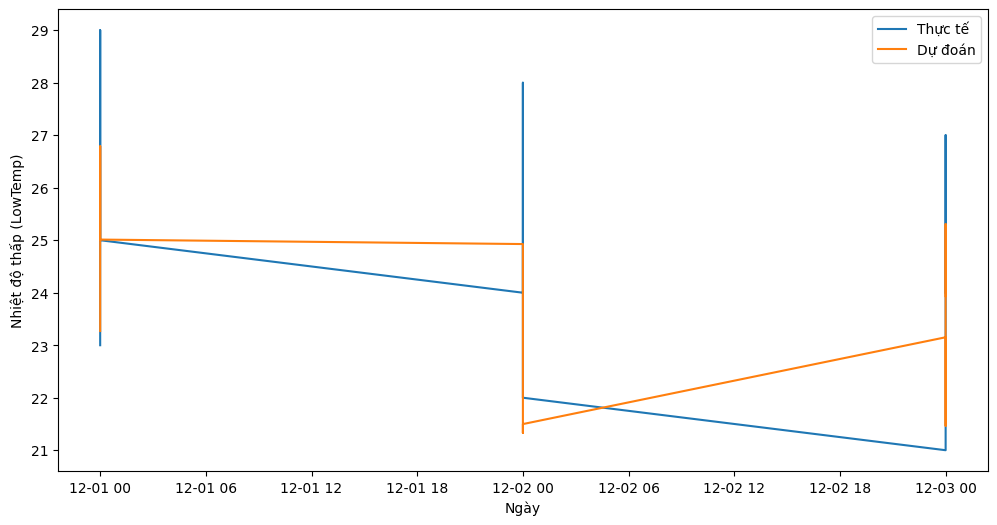

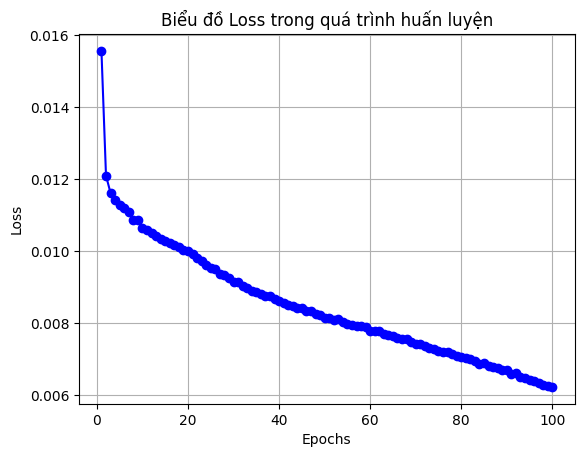

,Dự đoán,Thực tế
0,23.270802,23.0
1,23.327002,23.0
2,26.788242,29.0
3,25.012337,25.0
4,24.926975,24.0
5,24.344444,28.0
6,21.329588,22.0
7,21.498026,22.0
8,23.151428,21.0
9,21.465603,22.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Đọc dữ liệu vào DataFrame
data = pd.read_csv("/content/drive/MyDrive/DAMH/Data/PreparedData/prepared_data_weather.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Lọc dữ liệu
data = data[['LowTemp', 'HighTemp', 'Humidity', 'Barometer', 'WindDegrees', 'WindSpeed']]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data[data.index.month != data.index.month.max()]
test_data = data[data.index.month == data.index.month.max()]

# Tính toán giá trị tối thiểu và tối đa của cột 'LowTemp' gốc
min_low_temp = train_data['LowTemp'].min()
max_low_temp = train_data['LowTemp'].max()

# Chuẩn bị dữ liệu cho mô hình LSTM
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Tạo dữ liệu chuỗi thời gian
def create_time_series_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Dự đoán nhiệt độ thấp (LowTemp)
    return np.array(X), np.array(y)

look_back = 12  # Độ dài của cửa sổ thời gian
X_train, y_train = create_time_series_data(train_data_scaled, look_back)
X_test, y_test = create_time_series_data(test_data_scaled, look_back)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, train_data.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Dự đoán thời tiết cho 12 ngày tiếp theo
predicted_values = []
input_data = X_test[0, :, :]  # Sử dụng dữ liệu kiểm tra đầu tiên
for i in range(12):
    input_data_reshaped = input_data.reshape(1, look_back, train_data.shape[1])
    prediction = model.predict(input_data_reshaped)
    predicted_values.append(prediction[0, 0])
    input_data = np.roll(input_data, -1, axis=0)  # Đẩy dữ liệu cuối cùng ra để thêm dự đoán

# Chuyển ngược lại dự đoán
predicted_values = np.array(predicted_values).reshape(-1, 1) * (max_low_temp - min_low_temp) + min_low_temp

# Chuyển dữ liệu dự đoán và thực tế thành các mảng 1 chiều
predicted_values = predicted_values.reshape(-1)
actual_values = test_data['LowTemp'][:12].values

# Tạo DataFrame chứa dự đoán và thực tế
prediction_df = pd.DataFrame({'Dự đoán': predicted_values, 'Thực tế': actual_values})
# Vẽ biểu đồ dự đoán và thực tế
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:12], test_data['LowTemp'][:12], label='Thực tế')
plt.plot(test_data.index[:12], predicted_values, label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ thấp (LowTemp)')
plt.legend()
plt.show()

# Lấy giá trị loss từ history
loss_values = history.history['loss']

# Vẽ biểu đồ loss
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

prediction_df

Epoch 1/100
534/534 [==============================] - 8s 10ms/step - loss: 0.0181
Epoch 2/100
534/534 [==============================] - 9s 17ms/step - loss: 0.0117
Epoch 3/100
534/534 [==============================] - 8s 14ms/step - loss: 0.0114
Epoch 4/100
534/534 [==============================] - 10s 18ms/step - loss: 0.0113
Epoch 5/100
534/534 [==============================] - 5s 10ms/step - loss: 0.0112
Epoch 6/100
534/534 [==============================] - 6s 11ms/step - loss: 0.0112
Epoch 7/100
534/534 [==============================] - 4s 7ms/step - loss: 0.0111
Epoch 8/100
534/534 [==============================] - 4s 7ms/step - loss: 0.0110
Epoch 9/100
534/534 [==============================] - 5s 10ms/step - loss: 0.0109
Epoch 10/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0108
Epoch 11/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0106
Epoch 12/100
534/534 [==============================] - 9s 16ms/step - loss: 0.0105
Epoc

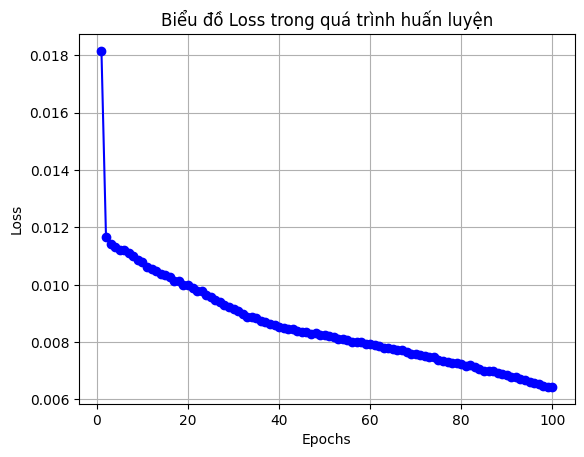

In [3]:

# Đọc dữ liệu vào DataFrame
data = pd.read_csv("/content/drive/MyDrive/DAMH/Data/PreparedData/prepared_data_weather.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Lọc dữ liệu
features = ['LowTemp', 'HighTemp', 'Humidity', 'Barometer', 'WindDegrees', 'WindSpeed']
data = data[features]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data[data.index.month != data.index.month.max()]
test_data = data[data.index.month == data.index.month.max()]

# Chuẩn bị dữ liệu cho mô hình LSTM
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

look_back = 12  # Độ dài của cửa sổ thời gian
X_train, y_train = create_time_series_data(train_data_scaled, look_back)
X_test, y_test = create_time_series_data(test_data_scaled, look_back)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(features))))  # Cần có một lớp đầu vào cho mỗi đặc trưng
model.add(Dense(len(features)))  # Cần có một lớp đầu ra cho mỗi đặc trưng
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Dự đoán tất cả các đặc trưng cho 12 buổi tiếp theo
predicted_values = []
input_data = X_test[0, :, :]  # Sử dụng dữ liệu kiểm tra đầu tiên
for i in range(12):
    input_data_reshaped = input_data.reshape(1, look_back, len(features))
    prediction = model.predict(input_data_reshaped)
    predicted_values.append(prediction[0])
    input_data = np.roll(input_data, -1, axis=0)  # Đẩy dữ liệu cuối cùng ra để thêm dự đoán

# Chuyển ngược lại dự đoán
predicted_values = np.array(predicted_values)
predicted_values = scaler.inverse_transform(predicted_values)

# Tạo DataFrame cho dự đoán và thực tế cho từng đặc trưng
prediction_dfs = {}
for i, feature in enumerate(features):
    predicted_feature = predicted_values[:, i]
    actual_feature = test_data[feature][:12].values
    prediction_df = pd.DataFrame({'Dự đoán': predicted_feature, 'Thực tế': actual_feature})
    prediction_dfs[feature] = prediction_df

# Lấy giá trị loss từ history
loss_values = history.history['loss']

# Vẽ biểu đồ loss
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [4]:
# Chuyển prediction_dfs thành một DataFrame
df_combined = pd.DataFrame()

for feature, prediction_df in prediction_dfs.items():
    # Đặt tên cột dự đoán và thực tế dựa trên tên đặc trưng
    prediction_col_name = f'{feature}_Dự đoán'
    actual_col_name = f'{feature}_Thực tế'

    # Đổi tên cột trong prediction_df
    prediction_df = prediction_df.rename(columns={'Dự đoán': prediction_col_name, 'Thực tế': actual_col_name})

    # Nối dự đoán và thực tế vào DataFrame chung
    if df_combined.empty:
        df_combined = prediction_df
    else:
        df_combined = pd.concat([df_combined, prediction_df], axis=1)

In [5]:
df_combined

,LowTemp_Dự đoán,LowTemp_Thực tế,HighTemp_Dự đoán,HighTemp_Thực tế,Humidity_Dự đoán,Humidity_Thực tế,Barometer_Dự đoán,Barometer_Thực tế,WindDegrees_Dự đoán,WindDegrees_Thực tế,WindSpeed_Dự đoán,WindSpeed_Thực tế
0,23.342674,23.0,27.330822,25.0,55.539875,98.0,906.595215,1008.0,125.372009,0.0,4.021903,0.833334
1,23.356783,23.0,27.351372,31.0,55.679134,84.0,906.649475,1010.0,126.356796,0.0,4.023765,1.388890
2,28.255369,29.0,32.231831,33.0,75.943352,57.0,957.674622,1007.0,223.322021,0.0,7.158934,2.222224
3,23.497911,25.0,27.506037,29.0,56.258507,83.0,908.265930,1008.0,128.891815,0.0,4.113183,1.111112
4,24.550472,24.0,28.553467,28.0,60.654240,73.0,919.300049,1008.0,149.726410,337.5,4.784765,2.777780
5,23.863607,28.0,27.857826,32.0,57.824268,45.0,912.220398,929.0,135.685913,315.0,4.340875,3.333336
6,22.482840,22.0,26.513451,25.0,51.744545,98.0,897.222107,1008.0,108.765205,0.0,3.534368,1.944446
7,22.347036,22.0,26.343817,32.0,51.390285,66.0,896.016907,1009.0,106.133705,0.0,3.394479,3.888892
8,23.080851,21.0,27.088169,24.0,54.448586,82.0,903.948853,923.0,120.235046,0.0,3.876851,1.666668
9,21.967411,22.0,25.978083,29.0,49.924091,74.0,892.464844,931.0,98.219826,0.0,3.154709,1.111112


In [6]:
# Tạo DataFrame mới chỉ chứa các cột dự đoán với tên gốc
df_predictions = df_combined.copy()

# Đặt lại tên cột dự đoán về tên gốc của dữ liệu
for feature in features:
    prediction_col_name = f'{feature}_Dự đoán'
    df_predictions[feature] = df_predictions[prediction_col_name]
    df_predictions = df_predictions.drop(columns=prediction_col_name)
    df_predictions = df_predictions.drop(columns=f'{feature}_Thực tế')
df_predictions.to_csv('/content/drive/MyDrive/DAMH/Data/PreparedData/df_predictions.csv')
df_predictions

,LowTemp,HighTemp,Humidity,Barometer,WindDegrees,WindSpeed
0,23.342674,27.330822,55.539875,906.595215,125.372009,4.021903
1,23.356783,27.351372,55.679134,906.649475,126.356796,4.023765
2,28.255369,32.231831,75.943352,957.674622,223.322021,7.158934
3,23.497911,27.506037,56.258507,908.265930,128.891815,4.113183
4,24.550472,28.553467,60.654240,919.300049,149.726410,4.784765
5,23.863607,27.857826,57.824268,912.220398,135.685913,4.340875
6,22.482840,26.513451,51.744545,897.222107,108.765205,3.534368
7,22.347036,26.343817,51.390285,896.016907,106.133705,3.394479
8,23.080851,27.088169,54.448586,903.948853,120.235046,3.876851
9,21.967411,25.978083,49.924091,892.464844,98.219826,3.154709
